<a href="https://colab.research.google.com/github/Sihan-A/PyTorch/blob/main/Multivariate_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Time Series

In [1]:
!pip install pytorch-lightning

     |████████████████████████████████| 923 kB 7.2 MB/s 
     |████████████████████████████████| 829 kB 43.8 MB/s 
     |████████████████████████████████| 119 kB 39.0 MB/s 
     |████████████████████████████████| 636 kB 52.3 MB/s 
     |████████████████████████████████| 282 kB 40.6 MB/s 
     |████████████████████████████████| 1.3 MB 60.1 MB/s 
     |████████████████████████████████| 294 kB 70.6 MB/s 
     |████████████████████████████████| 142 kB 72.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=f1d550554a307e791c868634a6ed9972bc3cdbccbb7a0e0ba049df7dedcdc82d
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [3]:
!gdown --id 1X6Hc0-58Wo0cCupCINH3e1yAcJ2CZaep

Downloading...
From: https://drive.google.com/uc?id=1X6Hc0-58Wo0cCupCINH3e1yAcJ2CZaep
To: /content/career-con-2019.zip
36.5MB [00:00, 99.0MB/s]


In [4]:
!unzip /content/career-con-2019.zip

Archive:  /content/career-con-2019.zip
  inflating: X_test.csv              
  inflating: X_train.csv             
  inflating: sample_submission.csv   
  inflating: y_train.csv             


In [33]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 16, 10

In [14]:
pl.seed_everything(42)

Global seed set to 42


42

In [19]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

In [20]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [21]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


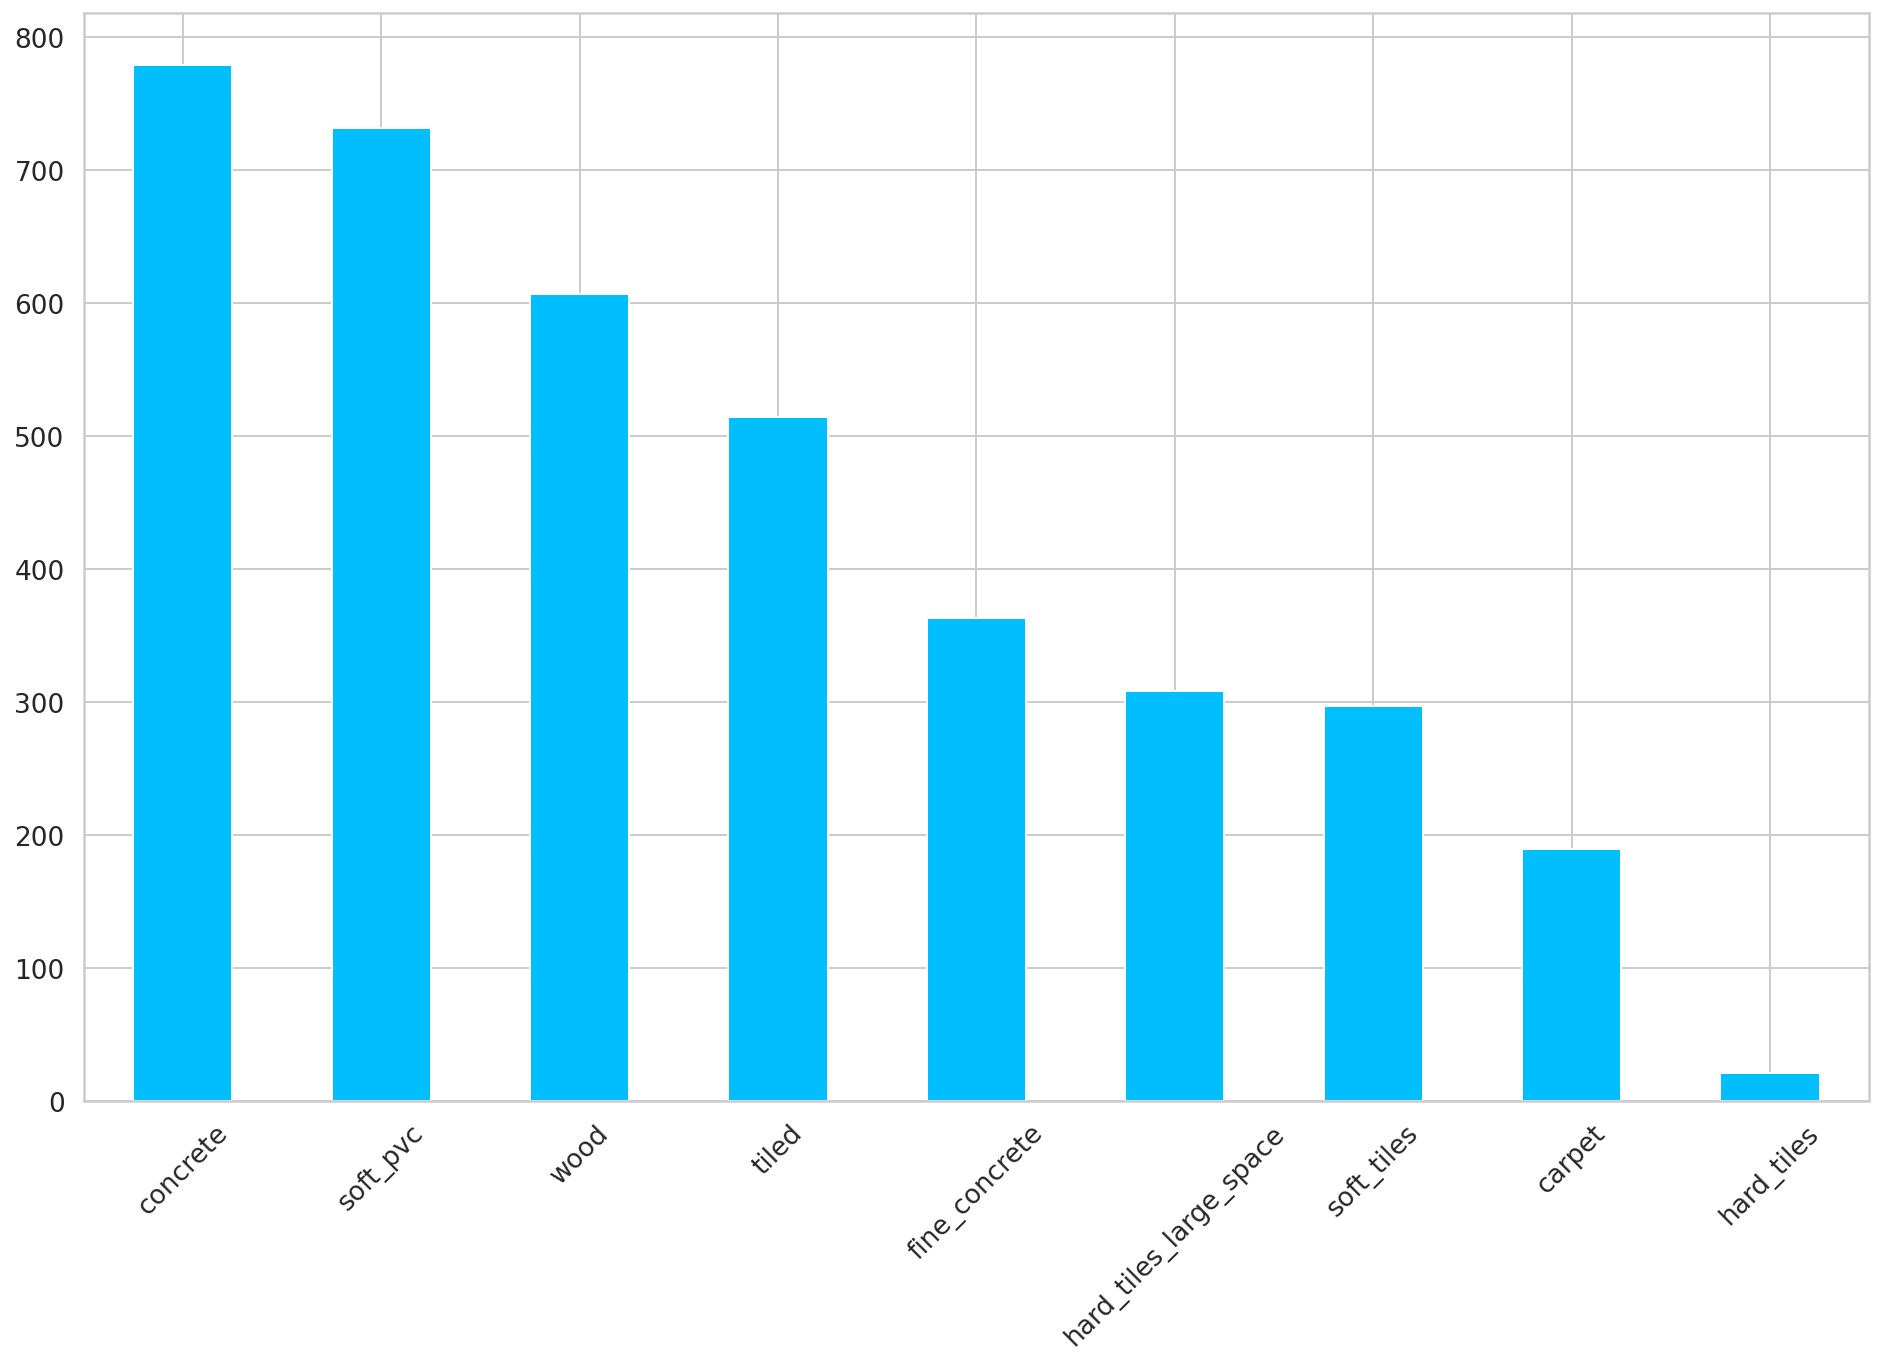

In [24]:
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show();

## Preprocessing

In [34]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

In [35]:
encoded_labels[:5]

array([2, 1, 1, 1, 6])

In [36]:
label_encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [37]:
y_train["label"] = encoded_labels

In [38]:
y_train.head()

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


In [40]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [41]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [43]:
X_train.series_id.value_counts()

2047    128
2645    128
2388    128
85      128
2132    128
       ... 
2216    128
1960    128
3753    128
1704    128
0       128
Name: series_id, Length: 3810, dtype: int64

In [46]:
(X_train.series_id.value_counts() == 128).sum()== len(y_train)

True